In [1]:
#8.3.2 배치 정규화와 드롭아웃

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
import os
import gzip

In [31]:
# Fashion MNIST download
trainset = torchvision.datasets.FashionMNIST(root='../chap08/data/', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

Using downloaded and verified file: ../chap08/data/FashionMNIST\raw\train-images-idx3-ubyte.gz
Extracting ../chap08/data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ../chap08/data/FashionMNIST\raw

Using downloaded and verified file: ../chap08/data/FashionMNIST\raw\train-labels-idx1-ubyte.gz
Extracting ../chap08/data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../chap08/data/FashionMNIST\raw

Using downloaded and verified file: ../chap08/data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz
Extracting ../chap08/data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../chap08/data/FashionMNIST\raw

Using downloaded and verified file: ../chap08/data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz
Extracting ../chap08/data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../chap08/data/FashionMNIST\raw



In [32]:
# 직접 불러오기
path = os.getcwd()  # 현재경로
labels_path = os.path.join(path,'data\\FashionMNIST','raw','%s-labels-idx1-ubyte.gz'%'train')
images_path = os.path.join(path,'data\\FashionMNIST','raw','%s-images-idx3-ubyte.gz'%'train')

with gzip.open(labels_path, 'rb') as lbpath:       # .gz파일 압축해제 & offset은 데이터의 시작위치
    y = np.frombuffer(lbpath.read(), dtype=np.uint8,offset=8)

with gzip.open(images_path, 'rb') as imgpath:
    X = np.frombuffer(imgpath.read(), dtype=np.uint8,offset=16).reshape(len(y), 28,28)


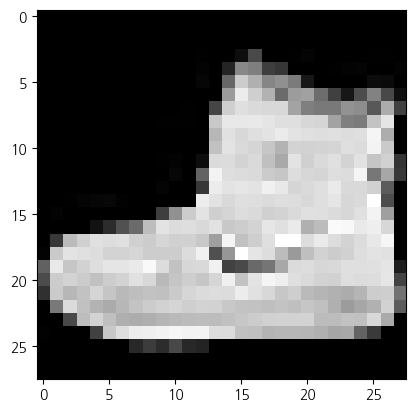

In [33]:
plt.imshow(X[0], cmap='gray')

In [ ]:
# 데이터 Augment를 사용하여 이미지,이미지_augment , label 반환
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img, label = self.x[idx], self.y[idx]
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img.transpose(method=Image.FLIP_LEFT_RIGHT))
            return (img1, img2), label
        else:
            return (img, img.transpose(method=Image.FLIP_LEFT_RIGHT)), label

'''
# 데이터 Augment를 사용하여 이미지 개수 2배
def __len__(self):
        return len(self.x) * 2를 해주고
def __getitem__(self, idx): 에서 적절한 처리를 해준다.
ex) if idx%2:
    img, label = self.x[idx//2], self.y[idx//2] 혹은

    if idx> len(self.x) 같이 내가 정하기 나름
    
'''


In [63]:
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img, label = self.x[idx], self.y[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor()   # (28,28) -> (1,28,28)로 바꿈
])

In [64]:
trainset = MyDataset(X, y, transform=transform)

# 데이터 로더 객체 생성
batch_size = 4 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [65]:
len(trainloader.dataset)

60000

In [66]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
3


In [67]:
def imshow(img, title):    
    plt.figure(figsize=(batch_size * 4, 4))
    plt.axis('off')
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [68]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])
    
    return images, labels

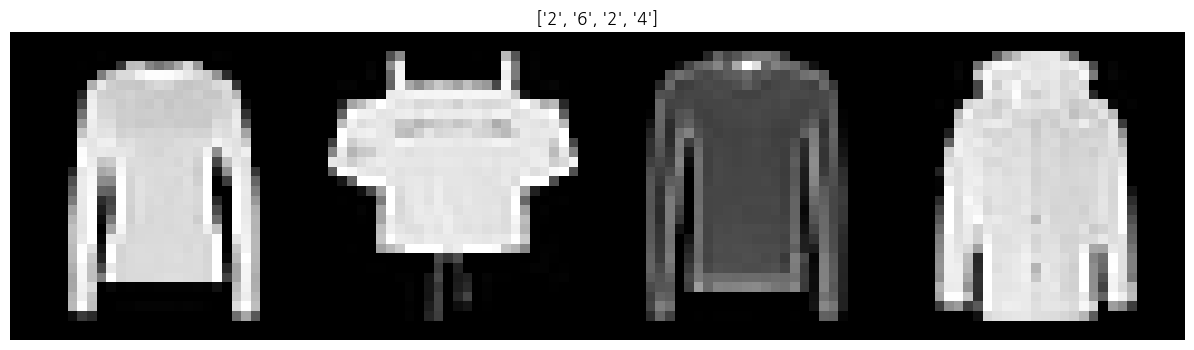

In [69]:
images, labels = show_batch_images(trainloader)

In [70]:
class NormalNet(nn.Module):
    def __init__(self): 
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [71]:
class BNNet(nn.Module):
    def __init__(self): 
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [72]:
model = NormalNet()
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [73]:
model_bn = BNNet()
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [74]:
batch_size = 512

In [75]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [76]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

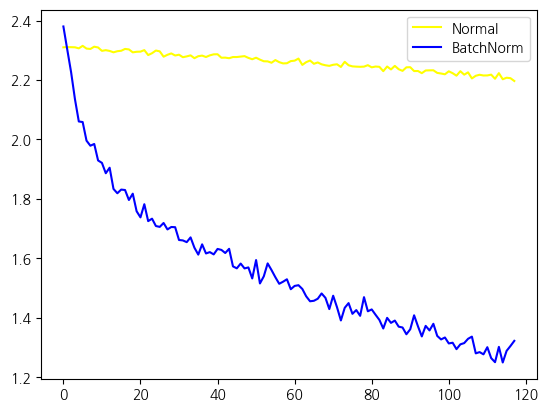

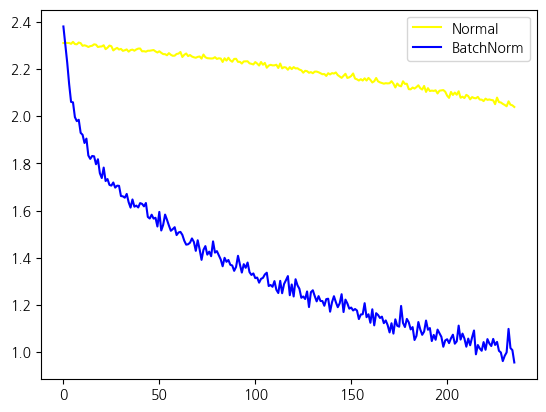

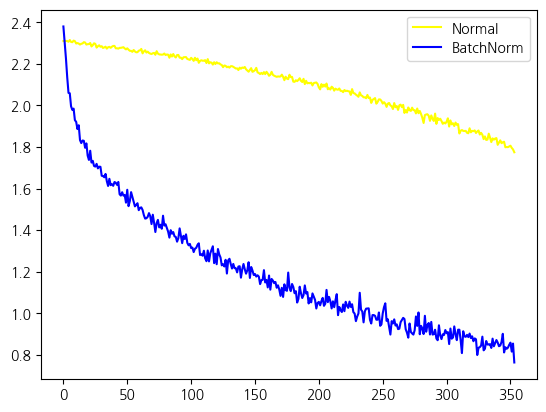

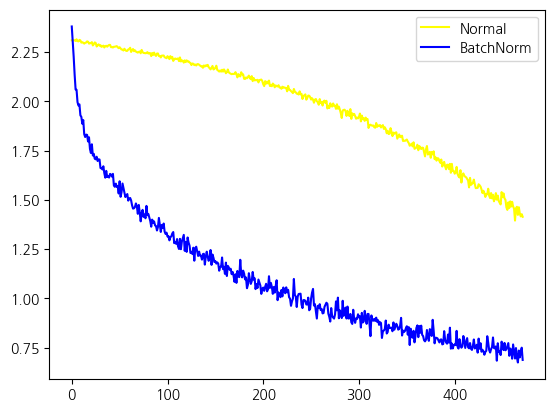

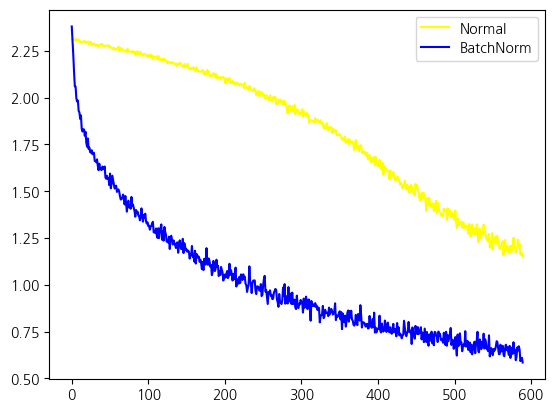

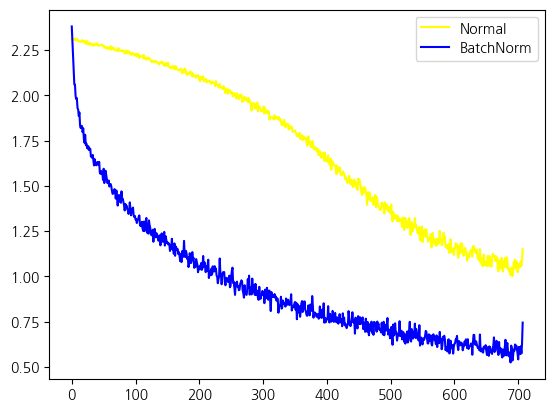

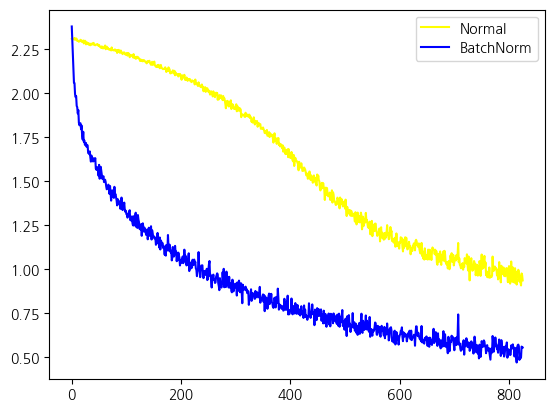

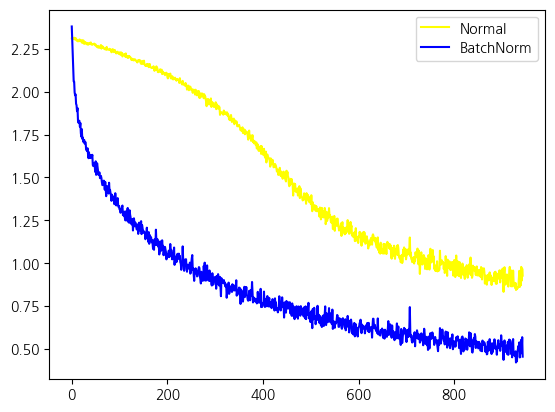

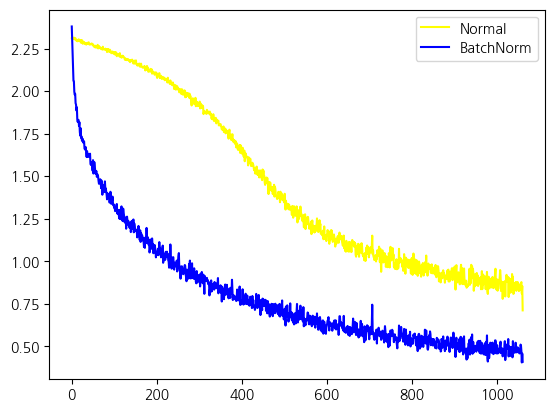

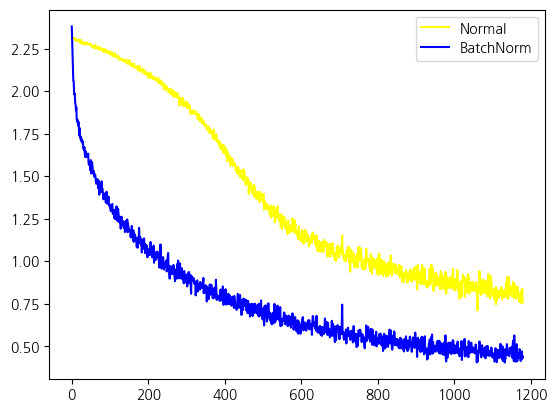

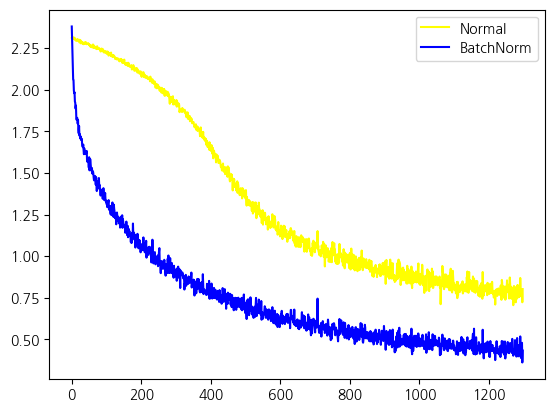

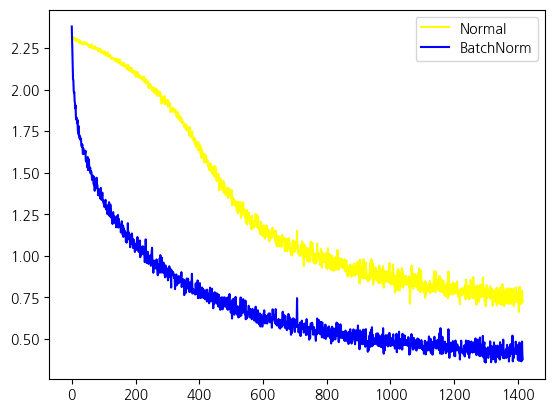

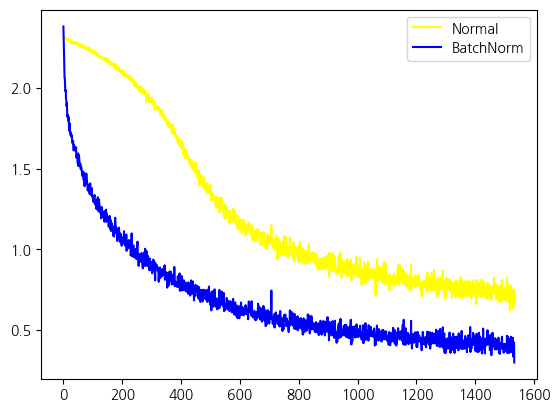

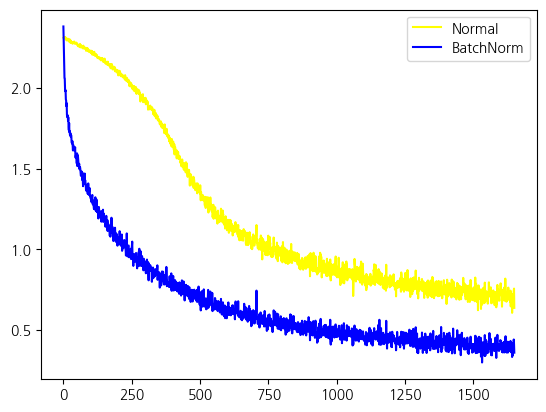

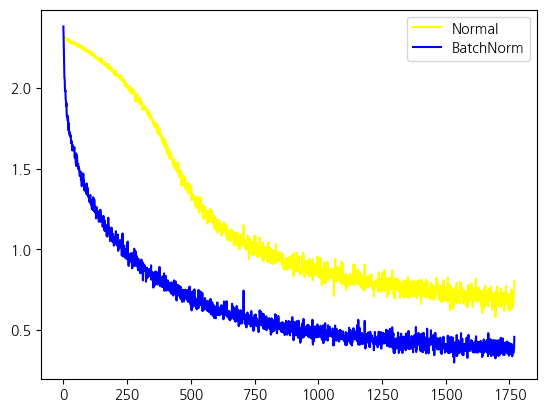

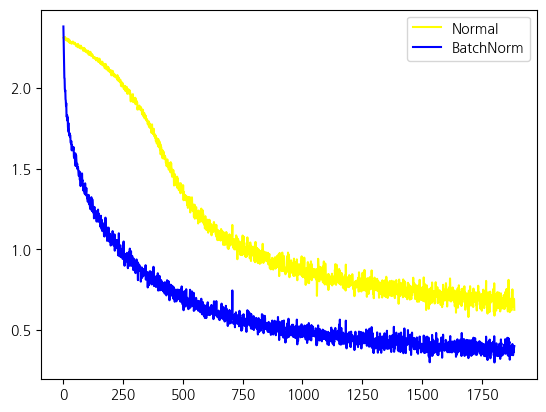

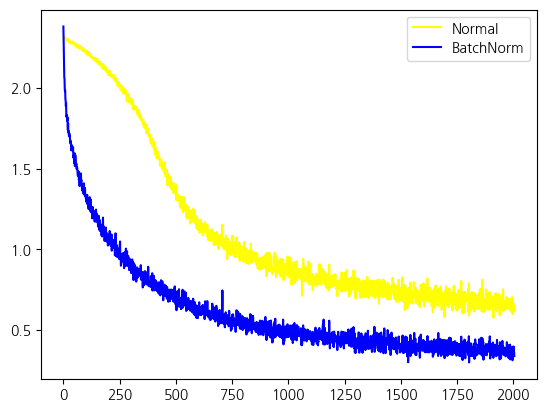

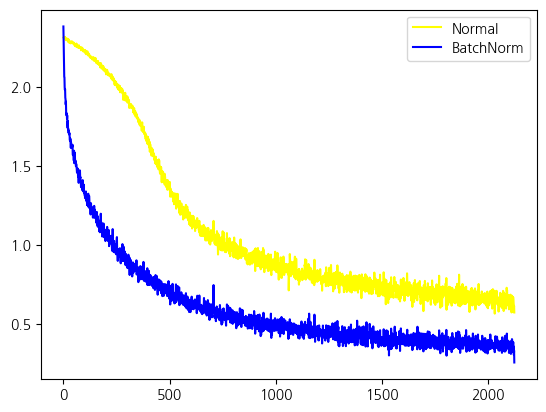

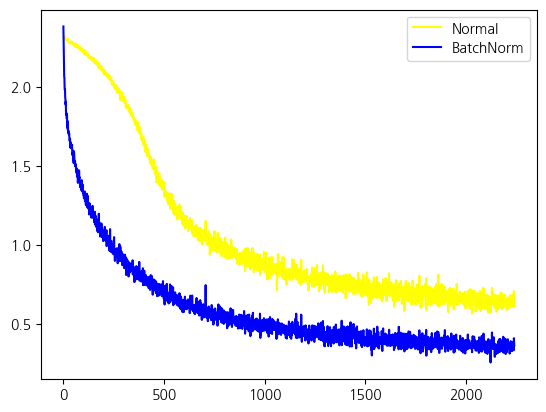

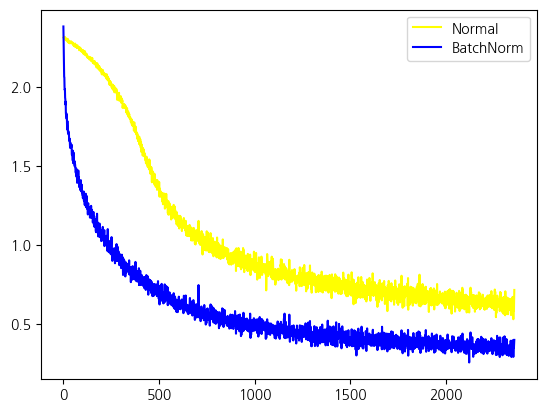

In [77]:
loss_arr = []
loss_bn_arr = []
max_epochs = 20

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        opt.zero_grad()
        outputs = model(inputs)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
           
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')    
    plt.legend()
    plt.show()

In [78]:
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


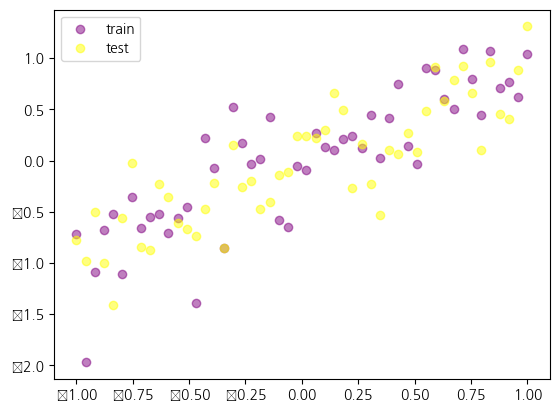

In [79]:
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

In [80]:
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [81]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

C:\Users\minki\AppData\Local\Temp\ipykernel_13252\1389617912.py:34: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.pause(0.05)


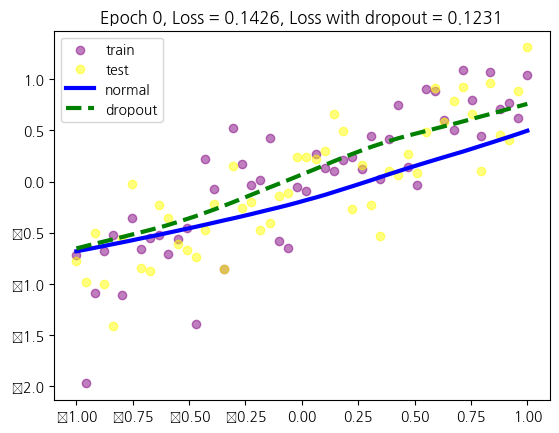

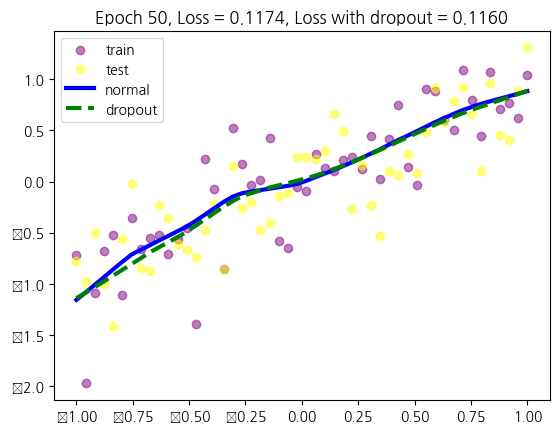

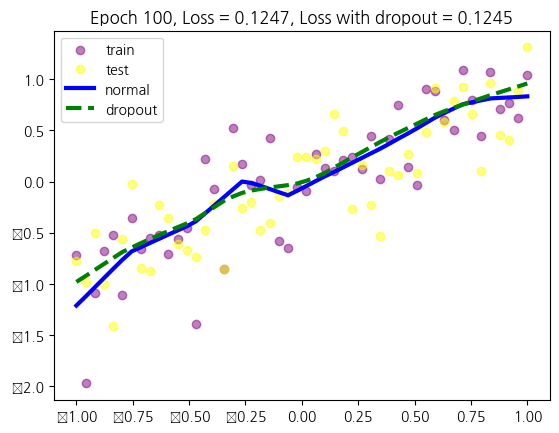

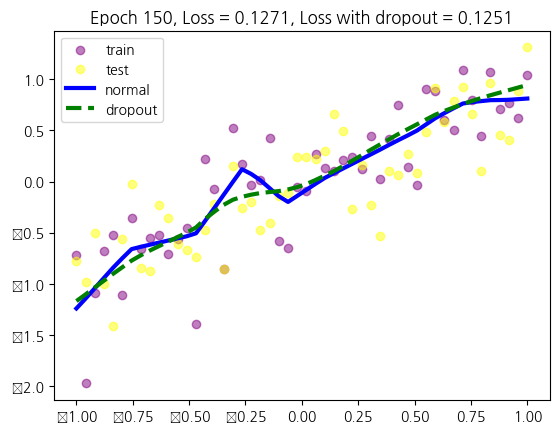

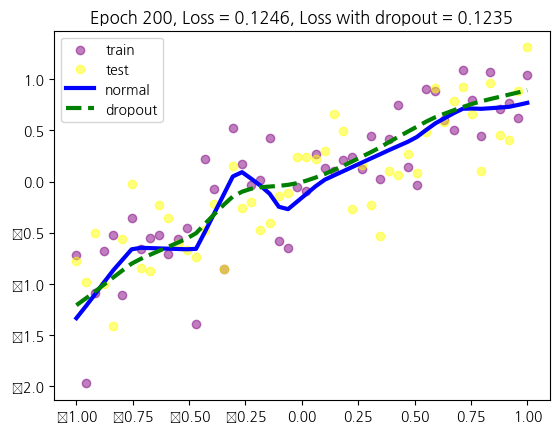

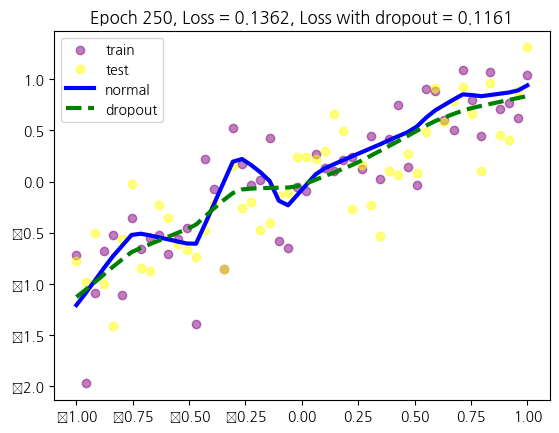

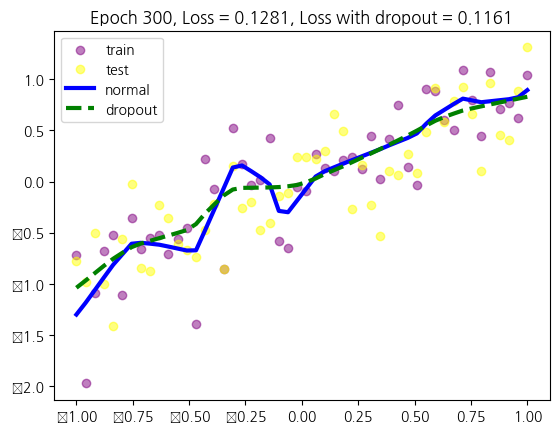

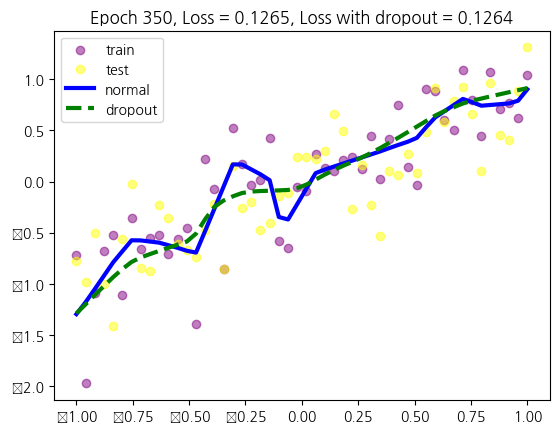

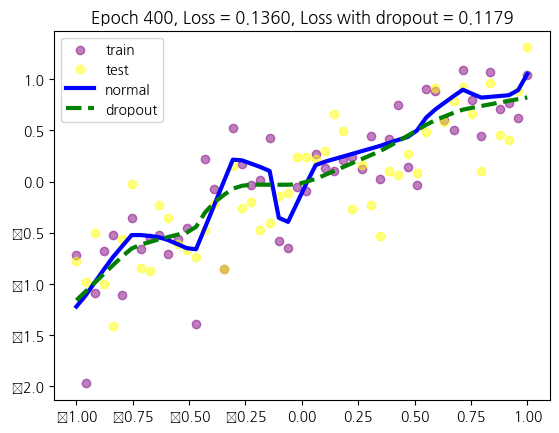

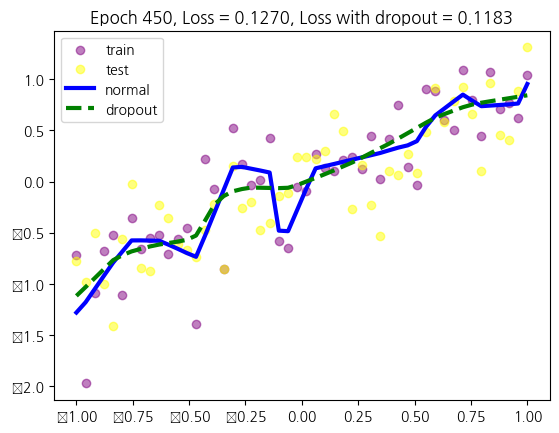

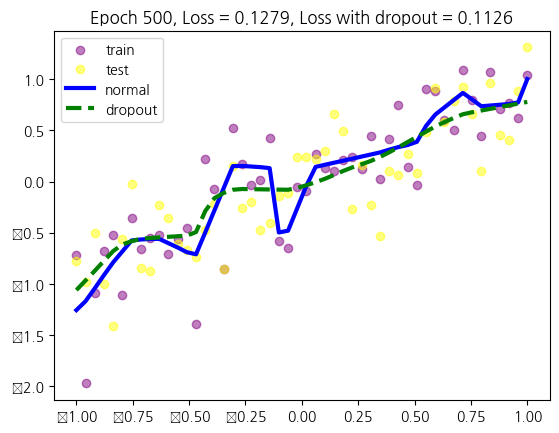

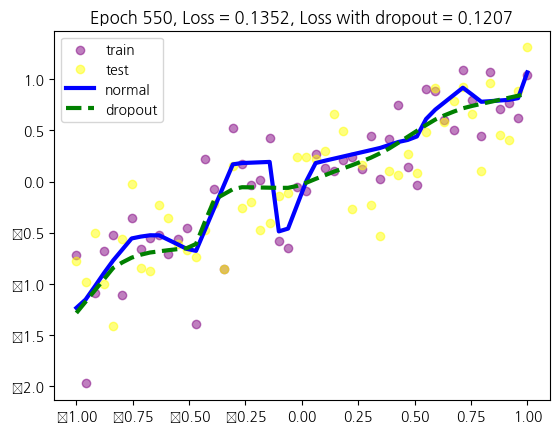

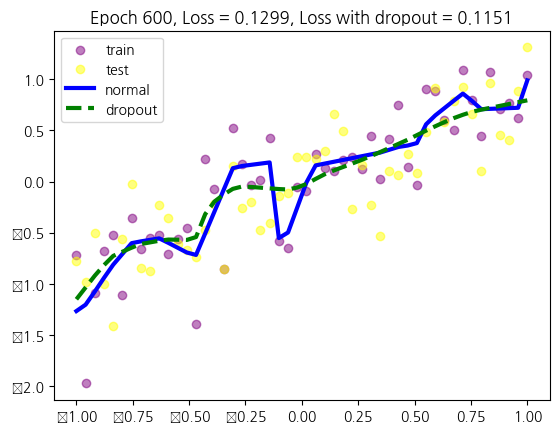

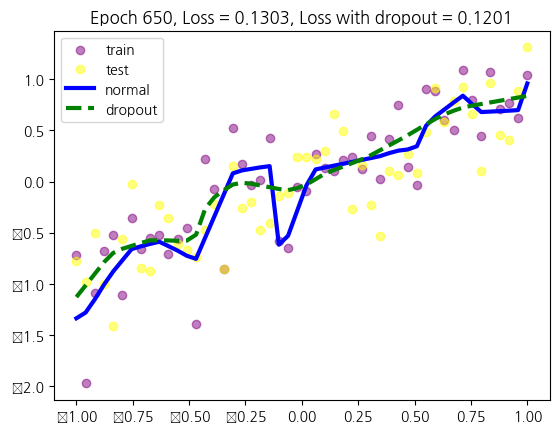

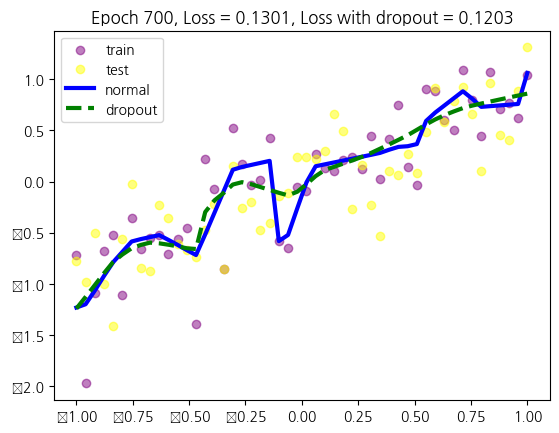

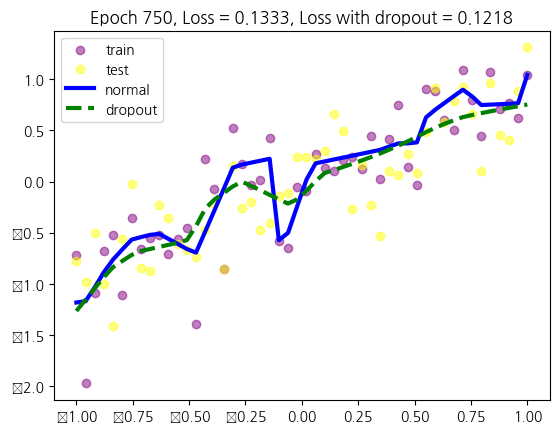

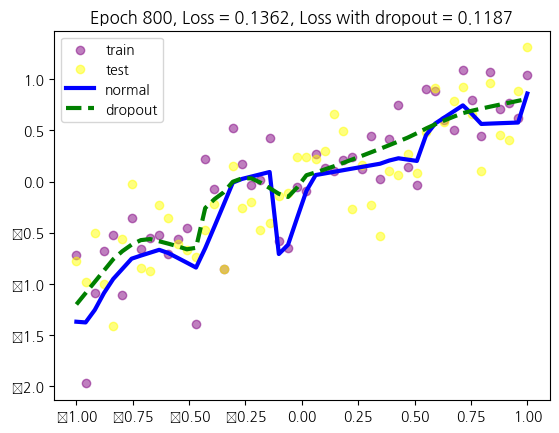

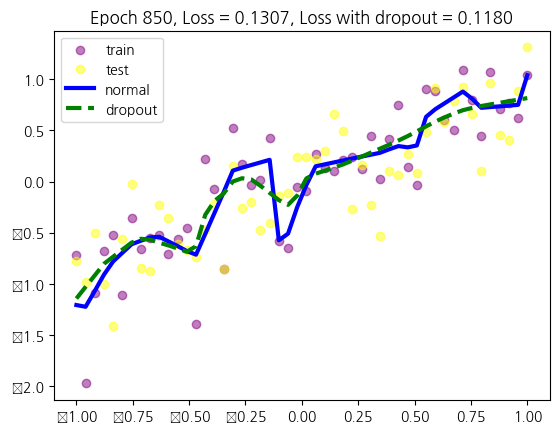

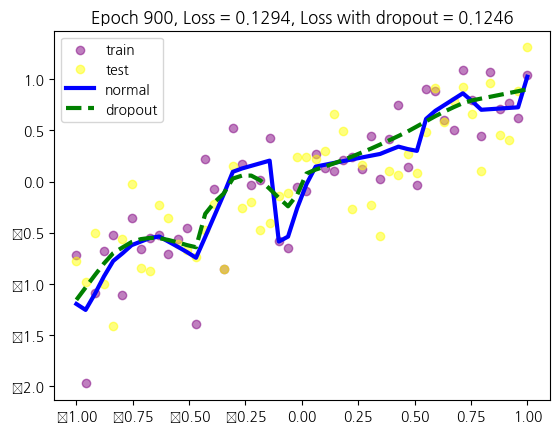

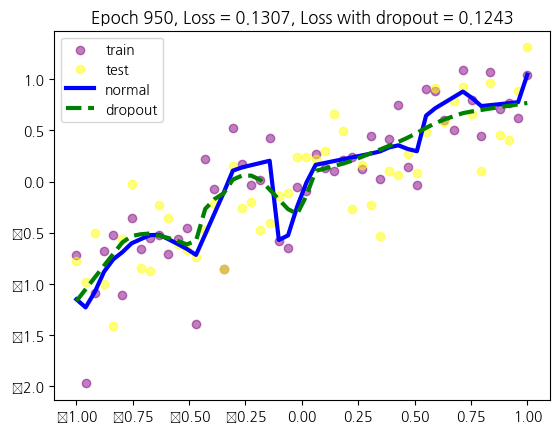

In [82]:
max_epochs = 1000
for epoch in range(max_epochs):    
    pred = model(x_train) 
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()    
    
    if epoch % 50 == 0:        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()        
        plt.pause(0.05)